In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from dateutil.parser import parse
from pandas.tseries.offsets import BDay
import pickle as pkl
import fnmatch
import pickle
import datetime as dt
from datetime import timedelta
import glob
from statsmodels.tsa.seasonal import STL
%matplotlib inline
import fathon
from fathon import fathonUtils as fu

In [2]:
mpl?

Object `mpl` not found.


In [3]:
import matplotlib.pyplot as plt

In [4]:
plt.style.use(os.path.join('/home/ak/.config/matplotlib','latexstyle.mplstyle'))

In [5]:
import stylised_facts_data_utilities.createLOB as createLOB

In [6]:
def open_pickle_file(path, pickle_file):
    file_loc = os.path.join(path, pickle_file)
    pickle_to_file = pickle.load(open(file_loc, "rb"))
    return pickle_to_file

In [7]:
##locations ##
#dataOnlyDrive = ('/media/ak/DataOnly')
# ''' Exterrnal Files'''
extPath = '/media/ak/My Passport/Experiment Data'
barketData = '/media/ak/My Passport/Barket Data/'
#cleanBloombergDataLocation = os.path.join(dataOnlyDrive, 'CleanBloombergData')
destinationFolder = '/media/ak/My Passport/ExperimentData/ProcessedDataForExperiments'

In [8]:
files =os.listdir(destinationFolder)

In [9]:
quoteFiles = open_pickle_file(destinationFolder, files[0])

In [10]:
targetDrive = barketData
bmrg_folders=[s for s in os.listdir(targetDrive ) if ('2y') in s]
bmrg_trades=sorted([s for s in os.listdir(targetDrive ) if s.endswith('y_trades')])
bmrg_quotes=sorted([s for s in os.listdir(targetDrive ) if s.endswith('y_quotes')])
bmrg_tickers=sorted([bmrg_trades[idx].split('_t')[0] for idx,_ in enumerate(bmrg_trades)])

In [11]:
Folder = os.path.join(targetDrive, bmrg_folders[0])
# tradesFolder = os.path.join(targetDrive, bmrg_folders[1])

list_Files = os.listdir(Folder)

In [12]:
fileLocation = os.path.join(Folder, list_Files[0])

In [13]:
raw_file = pd.read_csv(fileLocation)

In [14]:
exampleLOB =createLOB.calcLOB(createLOB.formatLOB(createLOB.createLOB(raw_file)))

/home/ak/Envs/resrPyth3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/ak/Envs/resrPyth3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/ak/Documents/Research/PaperCode/stylised_facts/stylised_facts_data_utilities/createLOB/__init__.py:350: RuntimeWarning: divide by zero encountered in log
  LOB['LogTradeSize'] = np.log(LOB.TradeVolume)


In [17]:
exampleLOB['BookPressure'] = (exampleLOB['BestBid'] * exampleLOB['BidSize'] - exampleLOB['BestAsk'] * exampleLOB['AskSize']) / (
            exampleLOB['BidSize'] + exampleLOB['AskSize'])

In [18]:
data =exampleLOB.BookPressure


In [19]:
res = STL(data, period=2).fit()

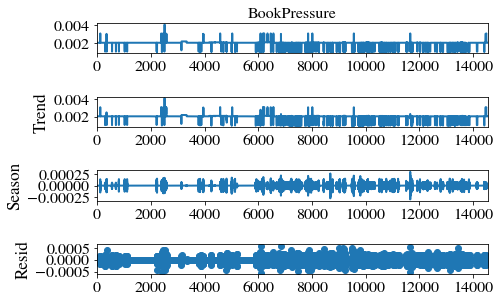

In [20]:
res.plot()
plt.show()


In [21]:
residuals =  np.array(res.resid)

In [22]:
a = fu.toAggregated(residuals)
pydfa = fathon.DFA(a)

In [23]:
winSizes = fu.linRangeByStep(10, 2000)
revSeg = True
polOrd = 3

In [24]:
%%time
n, F = pydfa.computeFlucVec(winSizes, revSeg=revSeg, polOrd=polOrd)

CPU times: user 28.6 s, sys: 0 ns, total: 28.6 s
Wall time: 7.59 s


In [25]:
H, H_intercept = pydfa.fitFlucVec()

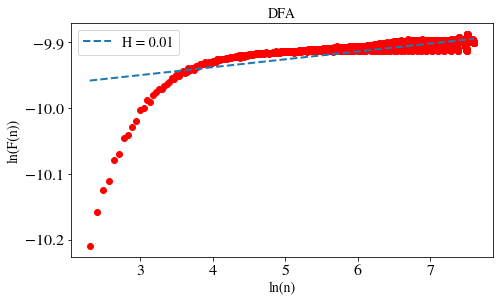

In [26]:
plt.plot(np.log(n), np.log(F), 'ro')
plt.plot(np.log(n), H_intercept+H*np.log(n), '--', label='H = {:.2f}'.format(H))
plt.xlabel('ln(n)', fontsize=14)
plt.ylabel('ln(F(n))', fontsize=14)
plt.title('DFA', fontsize=14)
plt.legend(loc=0, fontsize=14)

### MFDFA

In [27]:
pymfdfa = fathon.MFDFA(a)

In [28]:
winSizes = fu.linRangeByStep(10, 2000)
qs = np.arange(-3, 4, 0.1)
revSeg = True
polOrd = 1

In [ ]:
%%time
n, F = pymfdfa.computeFlucVec(winSizes, qs, revSeg=revSeg, polOrd=polOrd)

In [ ]:
list_H, list_H_intercept = pymfdfa.fitFlucVec()

In [ ]:
plt.plot(np.log(n), np.log(F[0, :]), 'ro')
plt.plot(np.log(n), list_H_intercept[0]+list_H[0]*np.log(n), '--', label='h_{:.1f} = {:.2f}'.format(qs[0], list_H[0]))
half_idx = int(len(qs)/2)
plt.plot(np.log(n), np.log(F[half_idx, :]), 'co')
plt.plot(np.log(n), list_H_intercept[half_idx]+list_H[half_idx]*np.log(n),
         '--', label='h_{:.1f} = {:.2f}'.format(qs[half_idx], list_H[half_idx]))
plt.plot(np.log(n), np.log(F[-1, :]), 'yo')
plt.plot(np.log(n), list_H_intercept[-1]+list_H[-1]*np.log(n), '--',
         label='h_{:.1f} = {:.2f}'.format(qs[-1], list_H[-1]))
plt.xlabel('ln(n)', fontsize=14)
plt.ylabel('ln(F(n))', fontsize=14)
plt.title('MFDFA', fontsize=14)
plt.legend(loc=0, fontsize=14)

In [ ]:
plt.plot(qs, list_H, 'ro-')
plt.xlabel('q', fontsize=14)
plt.ylabel('h(q)', fontsize=14)
plt.title('h(q)', fontsize=14)

In [ ]:
tau = pymfdfa.computeMassExponents()

In [ ]:
plt.plot(qs, tau, 'ro-')
plt.xlabel('q', fontsize=14)
plt.ylabel('$\\tau$(q)', fontsize=14)
plt.title('$\\tau$(q)', fontsize=14)

In [ ]:
alpha, mfSpect = pymfdfa.computeMultifractalSpectrum()

In [ ]:
plt.plot(alpha, mfSpect, 'ro-')
plt.xlabel('$\\alpha$', fontsize=14)
plt.ylabel('f($\\alpha$)', fontsize=14)
plt.title('f($\\alpha$)', fontsize=14)

### HT

In [ ]:
pyht = fathon.HT(a)

In [ ]:
scales = [100, 200, 1000]
mfdfaPolOrd = 1
polOrd = 1

In [ ]:
%%time
ht = pyht.computeHt(scales, mfdfaPolOrd=mfdfaPolOrd, polOrd=polOrd)

In [ ]:
plt.rc('font', size=14)
plt.figure(figsize=(10, 6))
w = 3 if len(scales) >= 3 else len(scales)
h = np.ceil(len(scales)/3)
for i, scale in enumerate(scales):
    plt.subplot(h, w, i+1)
    plt.plot(np.arange(1, len(ht[i, 0:len(a)-scale+1])+1), ht[i, 0:len(a)-scale+1],
             'r-', label='scale = {}'.format(scale))
    plt.xlabel('window number', fontsize=14)
    plt.ylabel('$h_t$', fontsize=14)
    plt.legend(loc=0, fontsize=14)
plt.subplots_adjust(hspace=0.6, wspace=0.3)